<a href="https://colab.research.google.com/github/YosukeSugiura/wise-p_speech_synthesis/blob/main/WISE_P_%E3%80%8C%E6%A9%9F%E6%A2%B0%E3%81%A7%E9%9F%B3%E5%A3%B0%E3%82%92%E5%90%88%E6%88%90%E3%81%97%E3%82%88%E3%81%86%E3%80%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### サイエンス体験サマースクール
#**「機械で音声を合成しよう」**

このコードは，人の音声(っぽい音)を機械で生成します．
まずは５種類の母音「あ」，「い」，「う」，「え」，「お」をそれぞれ作ってみましょう！


埼玉大学工学部 杉浦陽介・島村徹也

### インストール

In [ ]:
!pip install japanize-matplotlib
!pip install pyworld

### コード

In [ ]:
import librosa as lb
import numpy as np
from numpy.fft import fft, ifft, rfft
from librosa import stft, istft
from scipy import signal as sg
from scipy import interpolate
import matplotlib.pyplot as plt
import japanize_matplotlib
import soundfile as sf
import IPython
import pyworld as pw
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# パラメータ群
fs  = 16000
N   = 1024
S   = N//4
B   = N//2 + 1  # 周波数ビン数

In [ ]:
def freq_radius_to_complex(freq, radius, fs, radius_bias=0.5):
    p_list = []
    for f, r in zip(freq, radius):
        if f is None:
            continue
        theta   = f/fs * 2 * np.pi
        r       = r * (1-radius_bias) + radius_bias
        p1      = r * np.exp(-1j*theta)
        p2      = r * np.exp( 1j*theta)

        p_list.append(p1)
        if p1 != p2:
            p_list.append(p2)

    p_list.append(-0.5)

    return p_list


def Spectral_envelope(freq, peak, fs, N=1024):

    # 極を求める
    p = freq_radius_to_complex(freq, peak, fs)
    # 周波数特性を求める
    w, h = sg.freqz_zpk(1, p, 1, worN=N//2+1, fs=fs)
    H = np.abs(h)
    max_amp = 20*np.log10(np.max(H))
    H_nml = 20*np.log10(H)-max_amp # 正規化周波数特性 [dB]

    return sg.zpk2tf(1, p, 1/np.max(H))

def half_saw_tooth(f1, fs, t1=0.00008, t=3):

        period = fs / f1

        len = np.round(t*fs).astype(int)
        sig = np.zeros(len)

        for i in range(len):
            q = i % period
            if  i % period < 1:
                sig[i] = 1

        return sig


def calc_params(freq_pow):

    freq_pow = np.array(freq_pow)
    #print(freq_pow.shape)
    n_freq = fs/N * np.arange(B)

    itp_obj = interpolate.interp1d(freq_pow[:,0], freq_pow[:,1], kind="quadratic")
    h       = itp_obj(n_freq)

    return 10**(h/20)



def plot_Spectrum(f1, h, fs):


    # パルス音特性
    pulse_wave = half_saw_tooth(f1, fs, t=1)
    e       = rfft(pulse_wave, n=N)
    w       = fs/N * np.arange(B)

    # 周波数特性
    E       = 20*np.log10(np.abs(e))
    E       = E-np.max(E) # 最大 0dB になるよう正規化

    H       = 20*np.log10(np.abs(h))
    S       = E + H

    # 周波数特性をプロット
    plt.figure(figsize=[12,5])
    plt.plot(w, S)
    plt.plot(w, H, 'r')

    # ピーク位置をプロット
    peak_pos, _ = sg.find_peaks(H)
    plt.scatter(w[peak_pos], H[peak_pos], c='r')
    for i in peak_pos:
        plt.text(w[i], H[i]+3, '{0:.1f}'.format(H[i]), horizontalalignment='center' )

    plt.ylabel('振幅 [dB]')
    plt.xlabel('周波数 [Hz]')
    plt.xlim([20, 8000])
    plt.ylim([np.min(H)-10, np.max(H)+10])


def adjust_parameters(peaks, G, radius_bias=0.7):

    peaks_ = []
    for peak in peaks:
        peak = G + peak
        if peak < 0:
            peak = 0
        if peak > 0.99:
            peak = 0.99
        peaks_.append(peak)

    return peaks_

In [ ]:
def sound_generator(f0, sp, ap, fs):

    n_fft   = 2*(sp.shape[0]-1)
    n_frame = sp.shape[1]
    n_shift = n_fft//4
    n_smpl  = n_shift*(n_frame-1)+n_fft   # サンプル数

    # 周波数変動をなめらかに
    x = n_shift * np.arange(n_frame) + n_shift
    y = np.arange(n_smpl)
    Inter_obj = interpolate.PchipInterpolator(x, f0)
    f0_intp = Inter_obj(y)

    # パワースペクトル算出
    import pyworld as pw

    # 正弦波生成
    #e = np.zeros(n_smpl)
    #f0_max = np.max(f0_intp)
    #K = np.floor(fs/f0_max/2).astype(int)
    #for k in range(K):
    #    e += np.sin( 2 * np.pi * np.arange(n_smpl) * k * f0_intp/fs )

    # 白色雑音生成
    #w = np.random.randn(n_smpl)

    #E = stft(e, n_fft=n_fft, hop_length=n_shift, center=False)
    #W = stft(w, n_fft=n_fft, hop_length=n_shift, center=False)

    #X = ap * W + (1-ap) * E
    #Y = X * sp

    f0 = np.ascontiguousarray(f0, dtype=np.float64)
    sp = np.ascontiguousarray(sp.T, dtype=np.float64)
    ap = np.ascontiguousarray(ap.T, dtype=np.float64)
    e = pw.synthesize(f0, sp, ap, fs, frame_period=1000*S/fs)

    #plt.imshow(np.log10(np.abs(Y)), origin = "lower", aspect = "auto", cmap = "hot")
    #import librosa as lb

    #e = lb.griffinlim(np.abs(Y), hop_length=S, n_fft=N, momentum=0.1)
    #e = np.real(istft(Y, hop_length=n_shift, center=True))

    e = e * 0.5 / np.max(np.abs(e))

    e = fading(e)

    return e

def fading(s, fade_in_t = 0.02, fade_out_t = 0.1):

    L_in    = np.round(fade_in_t * fs).astype(int)
    L_out   = np.round(fade_out_t * fs).astype(int)
    s = fade_in(s, L_in)
    s = fade_out(s, L_out)

    return s

def fade_out(s, L):
    w = np.hanning(2*L)
    s[-L:] = w[L:] * s[-L:]
    return s

def fade_in(s, L):
    w = np.hanning(2*L)
    s[:L] = w[:L] * s[:L]
    return s

In [ ]:
class sound_creator:

    def __init__(self, h, ap=0.01):
        self.f0 = 100.0
        self.h  = h
        self.t  = 1
        self.ap = ap*np.ones(B)

    def __call__(self, t=1, f0=None):
        if f0 is not None: self.f0 = f0
        if t is not None:   self.t  = t
        return [self.f0, self.h, self.ap, self.t]

    def n_frame(self, t=None):
        if t is None: t = self.t
        return (t * fs - N) // S + 1

    def f0_array(self, f0=None, t=None):
        if f0 is None: f0 = self.f0
        if t is None : t = self.t
        return f0 * np.ones(self.n_frame(t))

    def sp_array(self, h=None, t=None):
        if h is None: h = self.h
        if t is None: t = self.t
        return np.repeat(h[:,np.newaxis], self.n_frame(t), axis=1)

    def ap_array(self, shape):
        return self.ap*np.ones(shape)

    def out(self, t=1, f0=None):
        if f0 is None: f0 = self.f0
        f0 = f0_array(f0, t)
        sp = sp_array(self.h, t)
        ap = ap_array(self.ap, t)
        s = sound_generator(f0, sp, ap, fs)

        return s

def n_frame(t):
    return np.array((t * fs - N) // S + 1).astype(int)

def f0_array(f0, t):
    return f0 * np.ones(n_frame(t))

def sp_array(h, t):
    return np.repeat(h[:,np.newaxis], n_frame(t), axis=1)

def ap_array(ap, t):
    return np.repeat(ap[:,np.newaxis], n_frame(t), axis=1)


In [ ]:
# 各オブジェクトをつなげて一つの音声にする
def connection(params_list, fs):
    # sc_obj_list : sound_creator オブジェクトのリスト

    f0, sp, ap = [], [], []
    for params in params_list:
        f0_, h_, ap_, t_ = params[0], params[1], params[2], params[3]
        f0.append(f0_array(f0_, t_))
        sp.append(sp_array(np.array(h_), t_))
        ap.append(ap_array(np.array(ap_), t_))

    f0, sp, ap = np.hstack(f0), np.hstack(sp), np.hstack(ap)

    # 平滑化
    order = 5
    f0 = np.hstack([f0[0]*np.ones(order), f0])
    f0 = sg.lfilter(np.ones(order)/(order),[1],f0)
    f0 = f0[order:]

    sp_ar = []
    for sp_ in sp:
        sp_ = np.hstack([sp_[0]*np.ones(order), sp_])
        sp_ = sg.lfilter(np.ones(order)/(order),[1],sp_)
        sp_ = sp_[order:]
        sp_ar.append(sp_)
    sp = np.array(sp_ar)

    #ap_ar = []
    #for ap_ in sp:
    #    ap_ = np.hstack([ap_[0]*np.ones(order), ap_])
    #    ap_ = sg.lfilter(np.ones(order)/(order),[1],ap_)
    #    ap_ = ap_[order:]
    #    ap_ar.append(ap_)
    #ap = np.array(ap_ar)

    s = sound_generator(f0, sp, ap, fs)
    return s

「s」を合成した音声の再生


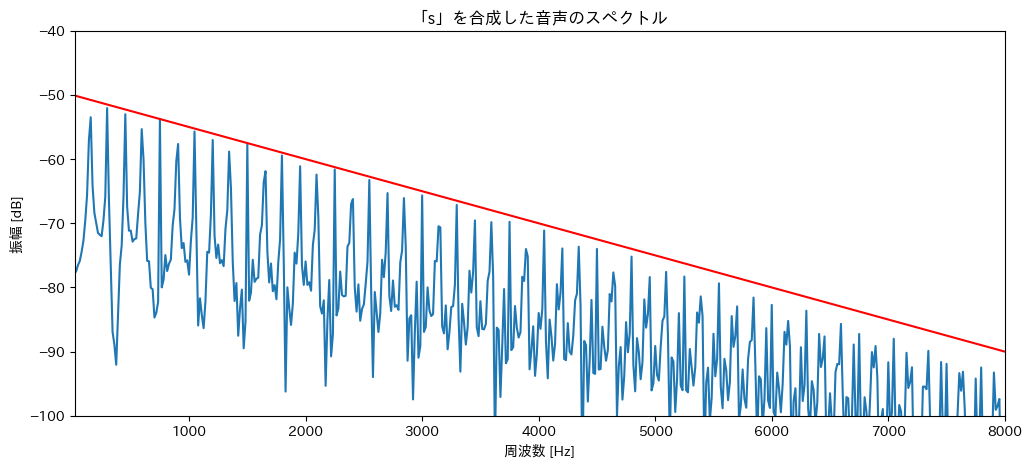

In [ ]:
# @title 子音「s」の生成

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 150

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-50),(1000, -55), (8000,-90)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「s」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_s = sound_creator(h, ap=0.0)

# 音声の再生
print('「s」を合成した音声の再生')
IPython.display.Audio(sound_s.out(f0=f0), rate=fs, normalize=False)
sf.write('pulse.wav',sound_s.out(f0=f0), fs )

「s」を合成した音声の再生


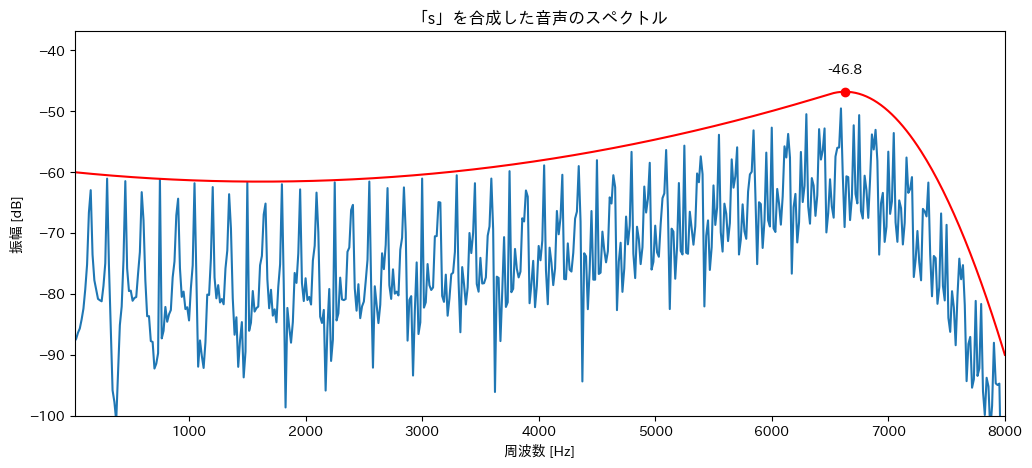

In [ ]:
# @title 子音「s」の生成

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 150

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-60), (6000, -50), (7000,-50), (8000,-90)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「s」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_s = sound_creator(h, ap=0.5)

# 音声の再生
print('「s」を合成した音声の再生')
IPython.display.Audio(sound_s.out(f0=f0), rate=fs, normalize=False)

「t」を合成した音声の再生


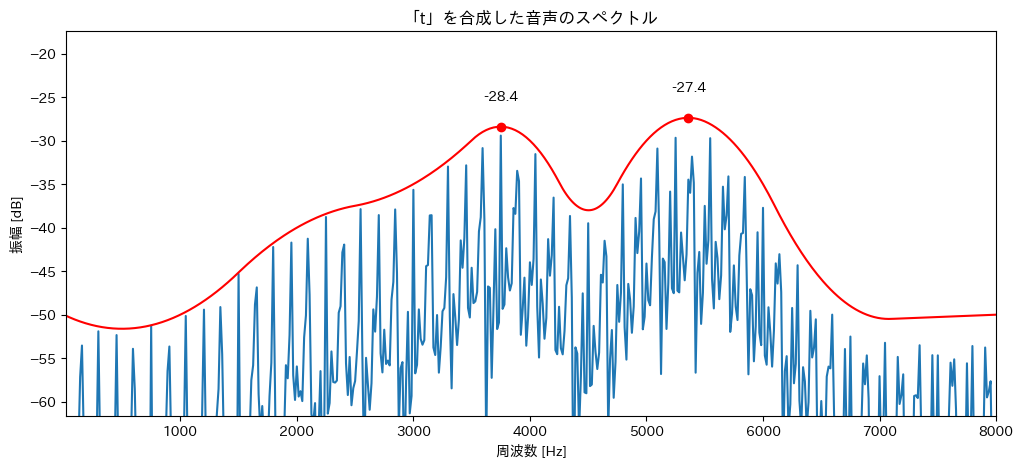

In [ ]:
# @title 子音「t」の生成

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 150

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-50), (1000, -50), (2000, -40),(3000, -35), (4000,-30), (4500,-38), (5000,-30), (6000,-35), (6200,-40), (68000,-30), (8000,-50)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「t」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_t = sound_creator(h, ap=0.9)

# 音声の再生
print('「t」を合成した音声の再生')
IPython.display.Audio(sound_t.out(f0=f0), rate=fs, normalize=False)

# 音声合成

## 「あ」の音声合成

「あ」を合成した音声の再生


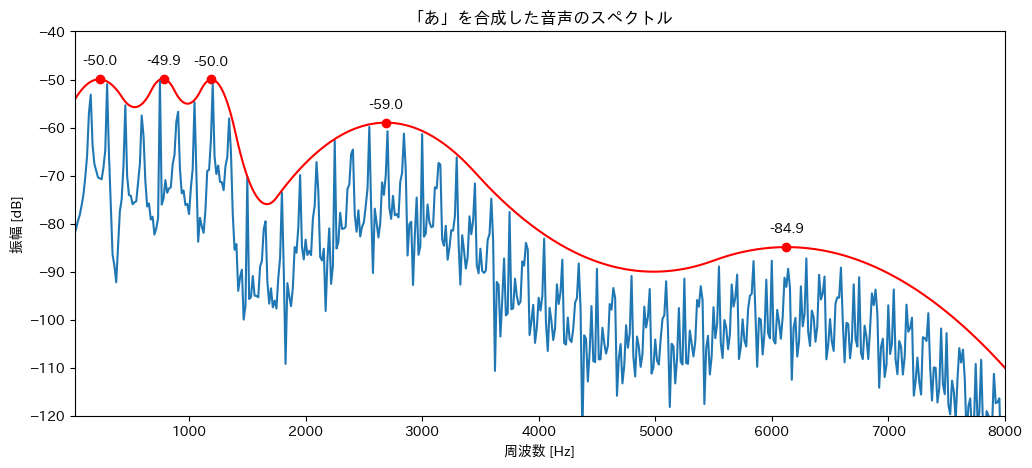

In [ ]:
# @title 音声パラメータの調整

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 150

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-55), (250,-50), (600,-55), (750,-50), (1000,-55),
        (1200, -50), (1600, -75), (1900, -70), (5000, -90), (6000,-85), (8000,-110)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「あ」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_a = sound_creator(h)

# 音声の再生
print('「あ」を合成した音声の再生')
IPython.display.Audio(sound_a.out(f0=f0), rate=fs, normalize=False)

## 「い」の音声合成

「い」を合成した音声の再生


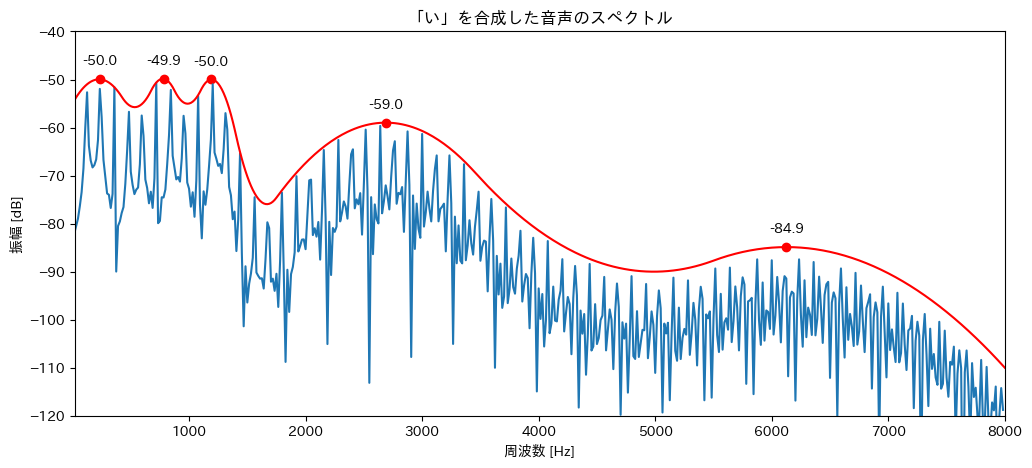

In [ ]:
# @title 音声パラメータの調整

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 120

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-55), (250,-50), (600,-55), (750,-50), (1000,-55),
        (1200, -50), (1600, -75), (1900, -70), (5000, -90), (6000,-85), (8000,-110)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「い」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_i = sound_creator(h)

# 音声の再生
print('「い」を合成した音声の再生')
IPython.display.Audio(sound_i.out(f0=f0), rate=fs, normalize=False)

## 「う」の音声合成

「う」を合成した音声の再生


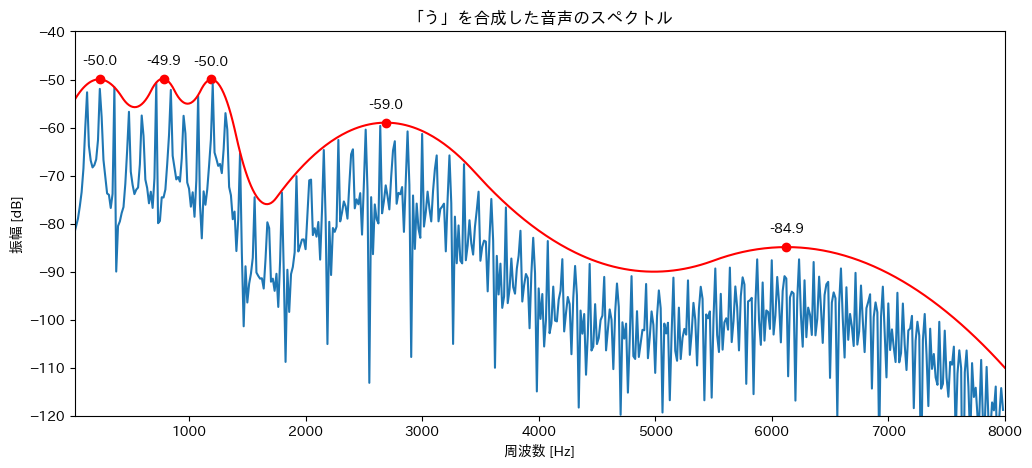

In [ ]:
# @title 音声パラメータの調整

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 120

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-55), (250,-50), (600,-55), (750,-50), (1000,-55),
        (1200, -50), (1600, -75), (1900, -70), (5000, -90), (6000,-85), (8000,-110)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「う」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_u = sound_creator(h)

# 音声の再生
print('「う」を合成した音声の再生')
IPython.display.Audio(sound_u.out(), rate=fs, normalize=False)

## 「え」の音声合成

「え」を合成した音声の再生


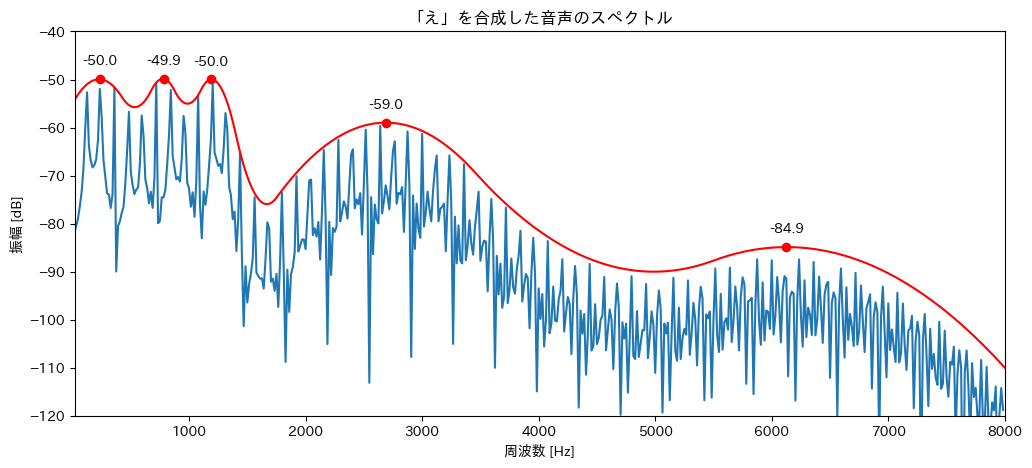

In [ ]:
# @title 音声パラメータの調整

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 120

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-55), (250,-50), (600,-55), (750,-50), (1000,-55),
        (1200, -50), (1600, -75), (1900, -70), (5000, -90), (6000,-85), (8000,-110)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「え」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_e = sound_creator(h)

# 音声の再生
print('「え」を合成した音声の再生')
IPython.display.Audio(sound_e.out(), rate=fs, normalize=False)

## 「お」の音声合成

「お」を合成した音声の再生


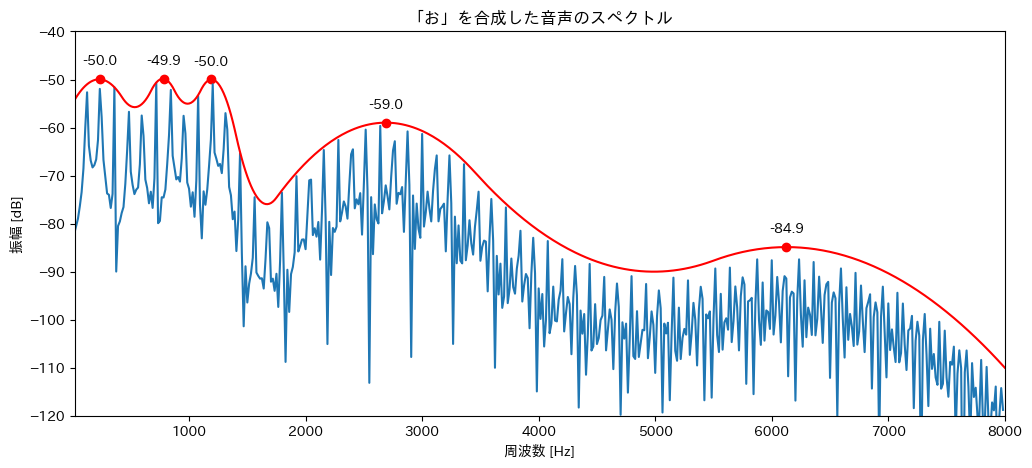

In [ ]:
# @title 音声パラメータの調整

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 120

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-55), (250,-50), (600,-55), (750,-50), (1000,-55),
        (1200, -50), (1600, -75), (1900, -70), (5000, -90), (6000,-85), (8000,-110)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「お」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_o = sound_creator(h)

# 音声の再生
print('「お」を合成した音声の再生')
IPython.display.Audio(sound_o.out(), rate=fs, normalize=False)

## 「ん」の音声合成

「ん」を合成した音声の再生


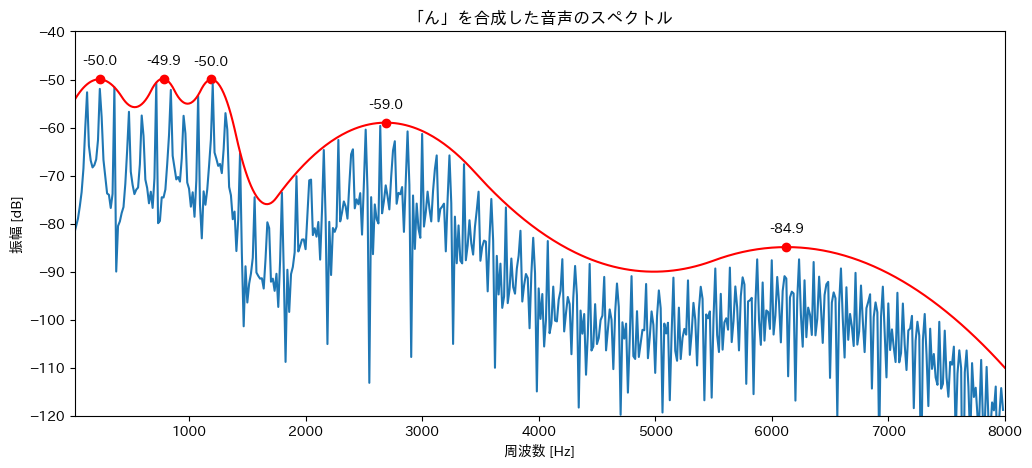

In [ ]:
# @title 音声パラメータの調整

#   1. 基本周波数を調整してください．(単位：Hz)

f0 = 120

#   2. 周波数とパワーの組み合わせを入力してください。
#       例) 0Hzで-50dB、250Hzで-40dB、500Hzで-30dB, 8000Hzで-110dBだったとき、こう書こう！
#
#           fp = [ (0, -50), (250, -40), (500, -30), (8000, -110) ]
#
#           注意：0Hz と 8000Hz は、必ず入れよう。

fp = [ (0,-55), (250,-50), (600,-55), (750,-50), (1000,-55),
        (1200, -50), (1600, -75), (1900, -70), (5000, -90), (6000,-85), (8000,-110)]

# 声導特性パラメータを算出
h = calc_params(fp)

# 音声スペクトル算出
plot_Spectrum(f0, h, fs)
plt.title('「ん」を合成した音声のスペクトル')

# 音声生成オブジェクト
sound_n = sound_creator(h)

# 音声の再生
print('「ん」を合成した音声の再生')
IPython.display.Audio(sound_n.out(), rate=fs, normalize=False)

# 単語の生成


In [ ]:
# @title 音声をつなげて単語を生成します

# ここに音素を並べる

phonemes = [ sound_t(0.07, 100), sound_i(1, 100)]

# 音声生成
sound = connection(phonemes, fs)

# 音声の再生
print('合成音声の再生')
IPython.display.Audio(sound, rate=fs, normalize=False)

合成音声の再生


In [ ]:
# @title 音声をファイルに保存します
# @markdown ### ファイル名を入力 (日本語×，アルファベットで):
# 自身の名前などを入れてください．
file_path = "gousei" # @param {type:"string"}
sf.write(file_path+'.wav',sound, fs)